Copyright 2023 The TensorFlow Authors.

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

Note: We recommend running this tutorial in a Colab notebook, with no setup required!  Just click "Run in Google Colab".

<div class="devsite-table-wrapper"><table class="tfo-notebook-buttons" align="left">
<td><a target="_blank" href="https://www.tensorflow.org/tfx/tutorials/tfx/penguin_simple">
<img src="https://www.tensorflow.org/images/tf_logo_32px.png"/>View on TensorFlow.org</a></td>
<td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/tfx/blob/master/docs/tutorials/tfx/penguin_simple.ipynb">
<img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a></td>
<td><a target="_blank" href="https://github.com/tensorflow/tfx/tree/master/docs/tutorials/tfx/penguin_simple.ipynb">
<img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">View source on GitHub</a></td>
<td><a href="https://storage.googleapis.com/tensorflow_docs/tfx/docs/tutorials/tfx/penguin_simple.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a></td>
</table></div>

# TFX Pipeline for Fine-Tuning and Converting an Large Language Model (LLM)


In this codelab, we use  KerasNLP to load a pre-trained Large Language Model (LLM) - GPT-2 model and finetune it to the Multi-News dataset. The dataset that is used in this demo is [Multi-News dataset](https://www.tensorflow.org/datasets/catalog/multi_news). After producing a finetuned model, the pipeline converts the model into a TFLite model, a format that can run on mobile devices, and a quantized TFLite model, which is a more efficient version of a TFLite model that represents the model's weights and activations using fewer bits.

## Why is this pipeline useful?
TFX pipelines are valuable tools for building and managing machine learning workflows in a production environment. They are more reproducible, scalable, and modular than simply running pure Python code. This makes them ideal for working with large language models, which require many complex steps that can be difficult to organize. TFX pipelines can also help you automate the finetuning and conversion process, which can save you a lot of time and effort.  

In addition, TFX pipelines can also help you track the lineage of your data and models using metadata. This means that you can easily see how your data and models were created and how they relate to each other. This can be helpful for debugging, auditing, and understanding the performance of your models.

## Note
*Note that GPT-2 is used here only to demonstrate the end-to-end process; the techniques and tooling introduced in this codelab are potentially transferrable to other generative language models such as Google T5.*

# Before You Begin

Colab offers different kinds of runtimes. Make sure to go to **Runtime -> Change runtime** type and choose the GPU Hardware Accelerator runtime since you will finetune the GPT-2 model. **This tutorial needs minimum 40GB of A100 GPU for execution. GPUs with less memory may result in GPU going OOM.**

# Set Up

We first install required python packages.

## Upgrade Pip
To avoid upgrading Pip in a system when running locally, check to make sure that we are running in Colab. Local systems can of course be upgraded separately.

In [ ]:
try:
  import colab
  !pip install --upgrade pip

except:
  pass

## Install TFX, KerasNLP and required Libraries

In [ ]:
!pip install -q git+https://github.com/keras-team/keras-nlp.git@google-io-2023\
tfx tensorflow-text more_itertools tensorflow_datasets

## Install "shapely<2"

This is a temporal solution to avoid an ImportError.


In [ ]:
!pip install -U google-cloud-aiplatform "shapely<2" -q

## Did you restart the runtime?

If you are using Google Colab, the first time that you run the cell above, you must restart the runtime by clicking above "RESTART RUNTIME" button or using `"Runtime > Restart runtime"` menu. This is because of the way that Colab loads packages.

*Let's check the TensorFlow and TFX library versions.*

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
print('TensorFlow version: {}'.format(tf.__version__))
from tfx import v1 as tfx
print('TFX version: {}'.format(tfx.__version__))

## Installing Interactive Context

An interactive context is used to provide global context when running a TFX pipeline in a notebook without using a runner or orchestrator such as Apache Airflow or Kubeflow. This style of development is only useful when developing the code for a pipeline, and cannot currently be used to deploy a working pipeline to production.

In [ ]:
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
context = InteractiveContext()

# Pipeline Overview

Below are the components that this pipeline follows.

* Custom Artifacts are artifacts that we have created for this pipeline. **Artifacts** are data that is produced by a component or consumed by a component. Artifacts are stored in a system for managing the storage and versioning of artifacts called MLMD.

* **Components** are defined as the implementation of an ML task that you can use as a step in your pipeline
* Aside from artifacts, **Parameters** are passed into the components to specify an argument.



# Create a TFDS ExampleGen
We create a custom ExampleGen component which we use to load a TensorFlow Datasets (TFDS) dataset. This uses a custom executor in a FileBasedExampleGen.




In [ ]:
from typing import Any, Dict, List, Text
import tensorflow_datasets as tfds
import apache_beam as beam
import json
from tfx.components.example_gen.base_example_gen_executor import BaseExampleGenExecutor
from tfx.components.example_gen.component import FileBasedExampleGen
from tfx.components.example_gen import utils
from tfx.dsl.components.base import executor_spec
import os
import pprint
pp = pprint.PrettyPrinter()

In [ ]:
@beam.ptransform_fn
@beam.typehints.with_input_types(beam.Pipeline)
@beam.typehints.with_output_types(tf.train.Example)
def _TFDatasetToExample(
    pipeline: beam.Pipeline,
    exec_properties: Dict[str, Any],
    split_pattern: str
    ) -> beam.pvalue.PCollection:
    """Read a TensorFlow Dataset and create tf.Examples"""
    custom_config = json.loads(exec_properties['custom_config'])
    dataset_name = custom_config['dataset']
    split_name = custom_config['split']

    builder = tfds.builder(dataset_name)
    builder.download_and_prepare()

    return (pipeline
            | 'MakeExamples' >> tfds.beam.ReadFromTFDS(builder, split=split_name)
            | 'AsNumpy' >> beam.Map(tfds.as_numpy)
            | 'ToDict' >> beam.Map(dict)
            | 'ToTFExample' >> beam.Map(utils.dict_to_example)
            )

class TFDSExecutor(BaseExampleGenExecutor):
  def GetInputSourceToExamplePTransform(self) -> beam.PTransform:
    """Returns PTransform for TF Dataset to TF examples."""
    return _TFDatasetToExample

For example demostration, we are using 20% of multi_news dataset. We can play around with "custom_config" to take in more data or the whole dataset.

In [ ]:
example_gen = FileBasedExampleGen(
    input_base='dummy',
    custom_config={'dataset':'multi_news', 'split':'train[:20%]'},
    custom_executor_spec=executor_spec.BeamExecutorSpec(TFDSExecutor))
context.run(example_gen, enable_cache=False)

We create a convenience utility to inspect datasets of TFExamples. The ratings dataset returns a dictionary of document and summary columns.

In [ ]:
def inspect_examples(component,
                     channel_name='examples',
                     split_name='train',
                     num_examples=1):
  # Get the URI of the output artifact, which is a directory
  full_split_name = 'Split-{}'.format(split_name)
  print('channel_name: {}, split_name: {} (\"{}\"), num_examples: {}\n'.format(
      channel_name, split_name, full_split_name, num_examples))
  train_uri = os.path.join(
      component.outputs[channel_name].get()[0].uri, full_split_name)
  print(train_uri)

  # Get the list of files in this directory (all compressed TFRecord files)
  tfrecord_filenames = [os.path.join(train_uri, name)
                        for name in os.listdir(train_uri)]

  # Create a `TFRecordDataset` to read these files
  dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")

  # Iterate over the records and print them
  for tfrecord in dataset.take(num_examples):
    serialized_example = tfrecord.numpy()
    example = tf.train.Example()
    example.ParseFromString(serialized_example)
    pp.pprint(example)

In [ ]:
inspect_examples(example_gen, num_examples = 1, split_name = 'train')

# Statistics Generator

`StatisticsGen` component computes statistics over your dataset for data analysis, such as the number of examples, the number of features, and the data types of the features. It uses the [TensorFlow Data Validation](https://www.tensorflow.org/tfx/data_validation/get_started) library. `StatisticsGen` takes as input the dataset we just ingested using `ExampleGen`.

*Note that the statistics generator is appropriate for tabular data, and therefore, text dataset for this LLM tutorial may not be the optimal dataset for the analysis with statistics generator.*

In [ ]:
from tfx.components import StatisticsGen

In [ ]:
statistics_gen = tfx.components.StatisticsGen(
    examples=example_gen.outputs['examples'], exclude_splits=['eval']
)
context.run(statistics_gen, enable_cache=False)

In [ ]:
context.show(statistics_gen.outputs['statistics'])

# SchemaGen

The `SchemaGen` component generates a schema based on your data statistics. (A schema defines the expected bounds, types, and properties of the features in your dataset.) It also uses the [TensorFlow Data Validation](https://www.tensorflow.org/tfx/data_validation/get_started) library.

Note: The generated schema is best-effort and only tries to infer basic properties of the data. It is expected that you review and modify it as needed.

`SchemaGen` will take as input the statistics that we generated with `StatisticsGen`, looking at the training split by default.


In [ ]:
schema_gen = tfx.components.SchemaGen(
    statistics=statistics_gen.outputs['statistics'],
    infer_feature_shape=False,
    exclude_splits=['eval'],
)
context.run(schema_gen, enable_cache=False)

In [ ]:
context.show(schema_gen.outputs['schema'])

# ExampleValidator

The `ExampleValidator` component detects anomalies in your data, based on the expectations defined by the schema. It also uses the [TensorFlow Data Validation](https://www.tensorflow.org/tfx/data_validation/get_started) library.

`ExampleValidator` will take as input the statistics from `StatisticsGen`, and the schema from `SchemaGen`.

In [ ]:
example_validator = tfx.components.ExampleValidator(
    statistics=statistics_gen.outputs['statistics'],
    schema=schema_gen.outputs['schema'],
    exclude_splits=['eval'],
)
context.run(example_validator, enable_cache=False)

After `ExampleValidator` finishes running, we can visualize the anomalies as a table.

In [ ]:
context.show(example_validator.outputs['anomalies'])

# Transform

For a structured and repeatable design of a TFX pipeline we will need a scalable approach to feature engineering. The `Transform` component performs feature engineering for both training and serving. It uses the [TensorFlow Transform](https://www.tensorflow.org/tfx/transform/get_started) library.


The Transform component uses a module file to supply user code for the feature engineering what we want to do, so our first step is to create that module file. We will only be working with the summary field.

**Note:**
*The %%writefile {_movies_transform_module_file} cell magic below creates and writes the contents of that cell to a file on the notebook server where this notebook is running (for example, the Colab VM). When doing this outside of a notebook you would just create a Python file.*

In [ ]:
import os
if not os.path.exists("modules"):
  os.mkdir("modules")

In [ ]:
_transform_module_file = 'modules/_transform_module.py'

In [ ]:
%%writefile {_transform_module_file}

import tensorflow as tf

def _fill_in_missing(x, default_value):
  """Replace missing values in a SparseTensor.

  Fills in missing values of `x` with the default_value.

  Args:
    x: A `SparseTensor` of rank 2.  Its dense shape should have size at most 1
      in the second dimension.
    default_value: the value with which to replace the missing values.

  Returns:
    A rank 1 tensor where missing values of `x` have been filled in.
  """
  if not isinstance(x, tf.sparse.SparseTensor):
    return x
  return tf.squeeze(
      tf.sparse.to_dense(
          tf.SparseTensor(x.indices, x.values, [x.dense_shape[0], 1]),
          default_value),
      axis=1)

def preprocessing_fn(inputs):

  outputs = {}
  outputs["summary"] = _fill_in_missing(inputs["summary"],"")
  return outputs

In [ ]:
preprocessor = tfx.components.Transform(
    examples=example_gen.outputs['examples'],
    schema=schema_gen.outputs['schema'],
    module_file=os.path.abspath(_transform_module_file))

In [ ]:
context.run(preprocessor, enable_cache=False)

Let's take a look at some of the transformed examples and check that they are indeed processed as intended.

In [ ]:
def pprint_examples(artifact, n_examples=2):
  print("artifact:", artifact)
  uri = os.path.join(artifact.uri, "Split-train")
  print("uri:", uri)
  tfrecord_filenames = [os.path.join(uri, name) for name in os.listdir(uri)]
  print("tfrecord_filenames:", tfrecord_filenames)
  dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")
  for tfrecord in dataset.take(n_examples):
    serialized_example = tfrecord.numpy()
    example = tf.train.Example.FromString(serialized_example)
    pp.pprint(example)

In [ ]:
pprint_examples(preprocessor.outputs['transformed_examples'].get()[0])

# Trainer

Trainer component trains an ML model, and it requires a model definition code from users.

The `run_fn` function in TFX's Trainer component is the entry point for training a machine learning model. It is a user-supplied function that takes in a set of arguments and returns a model artifact.

The `run_fn` function is responsible for:

*   Building the machine learning model.
*   Training the model on the training data.
*   Saving the trained model to the serving model directory.


## Write model training code
We will create a very simple fine-tuned model, with the preprocessing GPT-2 model. First, we need to create a module that contains the run_fn function for TFX Trainer because TFX Trainer expects the run_fn function to be defined in a module.  

In [ ]:
model_file = "modules/model.py"
model_fn = "modules.model.run_fn"

Now, we write the run_fn function:

This run_fn function first gets the training data from the `fn_args.examples` argument. It then gets the schema of the training data from the `fn_args.schema` argument. Next, it loads finetuned GPT-2 model along with its preprocessor. The model is then trained on the training data using the model.train() method.
Finally, the trained model weights are saved to the `fn_args.serving_model_dir` argument.


Now, we are going to work with Keras NLP's GPT-2 Model! You can learn about the full GPT-2 model implementation in KerasNLP on [GitHub]((https://github.com/keras-team/keras-nlp/blob/master/keras_nlp/models/gpt2/) or can read (and interactively test the model) on [Google IO2023 colab notebook](https://colab.research.google.com/github/tensorflow/codelabs/blob/main/KerasNLP/io2023_workshop.ipynb#scrollTo=81EZQ0D1R8LL ).


In [ ]:
import keras_nlp
from tensorflow import keras
import tensorflow as tf

In [ ]:
%%writefile {model_file}

import os
import time
from absl import logging
import keras_nlp
import more_itertools
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import tfx
import tfx.components.trainer.fn_args_utils
import gc


_EPOCH = 1
_BATCH_SIZE = 20
_INITIAL_LEARNING_RATE = 5e-5
_END_LEARNING_RATE = 0.0


def _input_fn(file_pattern: str) -> list:
  """Retrieves training data and returns a list of articles for training.

  For each row in the TFRecordDataset, generated in the previous ExampleGen
  component, create a new tf.train.Example object and parse the TFRecord into
  the example object. Articles, which are initially in bytes objects, are
  decoded into a string.

  Args:
    file_pattern: Path to the TFRecord file of the training dataset.

  Returns:
    A list of training articles.

  Raises:
    FileNotFoundError: If TFRecord dataset is not found in the file_pattern
    directory.
  """

  if os.path.basename(file_pattern) == '*':
    file_loc = os.path.dirname(file_pattern)

  else:
    raise FileNotFoundError(
        f"There is no file in the current directory: '{file_pattern}."
    )

  file_paths = [os.path.join(file_loc, name) for name in os.listdir(file_loc)]
  train_articles = []
  parsed_dataset = tf.data.TFRecordDataset(file_paths, compression_type="GZIP")
  for raw_record in parsed_dataset:
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    train_articles.append(
        example.features.feature["summary"].bytes_list.value[0].decode('utf-8')
    )
  return train_articles

def run_fn(fn_args: tfx.components.trainer.fn_args_utils.FnArgs) -> None:
  """Trains the model and outputs the trained model to a the desired location given by FnArgs.

  Args:
    FnArgs :  Args to pass to user defined training/tuning function(s)
  """

  train_articles =  pd.Series(_input_fn(
          fn_args.train_files[0],
      ))
  tf_train_ds = tf.data.Dataset.from_tensor_slices(train_articles)

  gpt2_preprocessor = keras_nlp.models.GPT2CausalLMPreprocessor.from_preset(
      'gpt2_base_en',
      sequence_length=256,
      add_end_token=True,
  )
  gpt2_lm = keras_nlp.models.GPT2CausalLM.from_preset(
      'gpt2_base_en', preprocessor=gpt2_preprocessor
  )

  processed_ds = (
      tf_train_ds.map(gpt2_preprocessor, tf.data.AUTOTUNE)
      .batch(_BATCH_SIZE)
      .cache()
      .prefetch(tf.data.AUTOTUNE)
  )

  gpt2_lm.include_preprocessing = False

  lr = tf.keras.optimizers.schedules.PolynomialDecay(
      5e-5,
      decay_steps=processed_ds.cardinality() * _EPOCH,
      end_learning_rate=0.0,
  )
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

  gpt2_lm.compile(
      optimizer=keras.optimizers.experimental.Adam(lr),
      loss=loss,
      weighted_metrics=['accuracy'],
  )

  gpt2_lm.fit(processed_ds, epochs=_EPOCH)
  if os.path.exists(fn_args.serving_model_dir):
    os.rmdir(fn_args.serving_model_dir)
  os.mkdir(fn_args.serving_model_dir)
  gpt2_lm.backbone.save_weights(
      filepath=os.path.join(fn_args.serving_model_dir, "model_weights"), save_format='tf'
  )
  del gpt2_lm, gpt2_preprocessor, processed_ds, tf_train_ds
  gc.collect()

In [ ]:
trainer = tfx.components.Trainer(
    run_fn=model_fn,
    examples=preprocessor.outputs['transformed_examples'],
    train_args=tfx.proto.TrainArgs(splits=['train']),
    eval_args=tfx.proto.EvalArgs(splits=['train']),
    schema=schema_gen.outputs['schema'],
)

In [ ]:
context.run(trainer, enable_cache=False)

# TFLite Conversion  

We can convert the pretrained model into a TFLite model, which is a specific type of model that is designed to be used on mobile and embedded devices.
TFLite models are smaller and faster than their TensorFlow counterparts, making them ideal for use on devices with limited resources.

We can optimize the model using quantization. TensorFlow Lite can be used to shrink down the model size and accelerate model inference by mapping an input of continuous values to a discrete set.

In this notebook you will use the [post-training dynamic range quantization](https://www.tensorflow.org/lite/performance/post_training_quant) by setting the converter optimization flag to 'tf.lite.Optimize.DEFAULT'. The rest of the conversion process is the same as before.

If you are interested in how TFLite works and would like to interactively work with it on colab notebook, you can explore this [Google IO2023 Colab Notebook](https://colab.research.google.com/github/tensorflow/codelabs/blob/main/KerasNLP/io2023_workshop.ipynb#scrollTo=ZVrW3jyVNEH9)

We will first create a TFLite artifact in order to save the TFLite model.

In [ ]:
from tfx import types
from tfx.types import artifact
from enum import Enum

Property = artifact.Property
PropertyType = artifact.PropertyType


DURATION_PROPERTY = Property(type=PropertyType.FLOAT)
EPOCH_PROPERTY = Property(type=PropertyType.INT)
SIZE_PROPERTY = Property(type=PropertyType.INT)
QUANTIZED_PROPERTY = Property(type=PropertyType.STRING)

class TFLite(types.Artifact):
  """Artifact that contains the trained model.

  * Properties:
    - `epoch`: The number of epochs it took to train the model.
    - `model_size`: The size of the model
    - `train_duration`: The total time elapsed for training and saving
       the model in seconds.
    - `is_quantized`: A boolean value indicating whether the model is the
       quantized TFLite model or not.
  """

  TYPE_NAME = 'TFLite'
  PROPERTIES = {
      'epoch': EPOCH_PROPERTY,
      'model_size': SIZE_PROPERTY,
      'conversion_duration': DURATION_PROPERTY,
      'is_quantized': QUANTIZED_PROPERTY,
        }

We have to initialize the gpt-2 model to ensure that we are working with a base model.

In [ ]:
gpt2_tokenizer = keras_nlp.models.GPT2Tokenizer.from_preset("gpt2_base_en")
gpt2_preprocessor = keras_nlp.models.GPT2CausalLMPreprocessor.from_preset(
    "gpt2_base_en",
    sequence_length=256,
    add_end_token=True,
)
gpt2_lm = keras_nlp.models.GPT2CausalLM.from_preset("gpt2_base_en", preprocessor=gpt2_preprocessor)

First, you wrap the generate() function into a TensorFlow concrete function. The @tf.function decorator is used to convert a Python function to a TensorFlow graph function. This can improve the performance of the function by optimizing the TensorFlow operations that are executed.



In [ ]:
@tf.function
def generate(prompt, max_length):
    return gpt2_lm.generate(prompt, max_length)

concrete_func = generate.get_concrete_function(tf.TensorSpec([], tf.string), 100)

In [ ]:
"""A Conversion Component that transforms a trained model into TFLite Model.
This is a conversion component that the users can specify whether the model will
be quantized or not.
"""
import time

@tfx.dsl.components.component
def Conversion(
    trained_model: tfx.dsl.components.InputArtifact[tfx.types.standard_artifacts.Model],
    tflite_model: tfx.dsl.components.OutputArtifact[TFLite],
    is_quantized: tfx.dsl.components.Parameter[bool]) -> None:

    # Creating a tflite model for generate function
    trained_model_dir = os.path.join(trained_model.uri,'Format-Serving', 'model_weights')
    gpt2_lm.load_weights(trained_model_dir)
    gpt2_lm.jit_compile = False
    generate_converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func],
                                                            gpt2_lm)
    generate_converter.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
        tf.lite.OpsSet.SELECT_TF_OPS,  # enable TensorFlow ops.
    ]
    generate_converter.allow_custom_ops = True
    if is_quantized:
      generate_converter.optimizations = [tf.lite.Optimize.DEFAULT]

    generate_converter.target_spec.experimental_select_user_tf_ops = [
        "UnsortedSegmentJoin",
        "UpperBound",
    ]
    generate_converter._experimental_guarantee_all_funcs_one_use = True
    start = time.time()
    generate_tflite = generate_converter.convert()
    end = time.time()
    generate_path = os.path.join(tflite_model.uri, "quantized_gpt2_generate.tflite")
    with open(generate_path, "wb") as f:
      f.write(generate_tflite)
    tflite_model.conversion_duration = end - start
    tflite_model.model_size = os.path.getsize(generate_path)

    # Creating a tflite model for Runner (needed for calculating perplexity)
    runner_converter = tf.lite.TFLiteConverter.from_keras_model(gpt2_lm)
    if is_quantized:
      runner_converter.optimizations = [tf.lite.Optimize.DEFAULT]
    runner_converter.target_spec.supported_ops = [
      tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
      tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
    ]
    runner_converter.allow_custom_ops = True
    runner_converter.target_spec.experimental_select_user_tf_ops = ["UnsortedSegmentJoin", "UpperBound"]
    runner_converter._experimental_guarantee_all_funcs_one_use = True

    runner_tflite = runner_converter.convert()
    runner_path = os.path.join(tflite_model.uri, "quantized_gpt2_runner.tflite")
    with open(runner_path, "wb") as f:
      f.write(runner_tflite)
    if is_quantized:
      tflite_model.is_quantized = "QUANTIZED"
    else:
      tflite_model.is_quantized = "UNQUANTIZED"

Similarly, let's convert the trained model into a TFLite model by running the Conversion component with parameter 'is_quantized' specified to False.

In [ ]:
tflite_model = Conversion(trained_model = trainer.outputs['model'], is_quantized = False)

In [ ]:
context.run(tflite_model, enable_cache = False)

Let's convert the trained model into a Quantized TFLite model by running the Conversion component with parameter 'is_quantized' specified to True.

In [ ]:
quantized_model = Conversion(trained_model = trainer.outputs['model'], is_quantized = True)

In [ ]:
context.run(quantized_model, enable_cache = False)

# Inference and Evaluation

Now that we have fine-tuned the model and converted them to a TFlite model, let's test these models to make inferences. We will create a EvaluationMetric artifact since we want to save the inference results.


In [ ]:
from tfx.types import artifact
from tfx import types

Property = artifact.Property
PropertyType = artifact.PropertyType

DURATION_PROPERTY = Property(type=PropertyType.FLOAT)
EVAL_OUTPUT_PROPERTY = Property(type=PropertyType.STRING)

class EvaluationMetric(types.Artifact):
  """Artifact that contains metrics for a model.

  * Properties:

     - 'model_prediction_time' : time it took for the model to make predictions
     based on the input text.
     - 'model_evaluation_output_path' : saves the path to the CSV file that
     contains the model's prediction based on the testing inputs.
  """
  TYPE_NAME = 'Evaluation_Metric'
  PROPERTIES = {
      'model_prediction_time': DURATION_PROPERTY,
      'model_evaluation_output_path': EVAL_OUTPUT_PROPERTY,
  }

Here, we are defining a helper function to run inference with a given input and a TFLite model. Note that here TensorFlow Text ops are registered as custom ops so that the interpreter can run smoothly.



In [ ]:
from tensorflow.lite.python import interpreter
import tensorflow_text as tf_text
def run_inference(input, generator):
  output = generator(prompt=np.array([input]))
  output_text = output["output_0"].item(0).decode('utf-8')
  return output_text

In order to produce logits with TFLite models, we need to create a separate interpreter such that takes in a TFLite model as input and returns an object defined as "runner" that we need later for comupting perplexity for tflite models.


The function first creates an interpreter.InterpreterWithCustomOps object, which is a specialized interpreter that can run TFLite models that use custom TensorFlow ops. The interpreter.InterpreterWithCustomOps object is then configured to use the TFText ops.

Next, the function resizes the input tensors to the specified size. This is necessary because the default size of input tensors in TFLite models is [1,1]. Finally, the function allocates the tensors in the interpreter and gets the signature list.

In [ ]:
from tensorflow.lite.python import interpreter
def create_runner(tflite_model):
  interp = interpreter.InterpreterWithCustomOps(
      model_content=tflite_model,
      custom_op_registerers=tf_text.tflite_registrar.SELECT_TFTEXT_OPS)

  # Need to resize tensor inputs or they will be [1,1]!
  interp.resize_tensor_input(0, (1,255))
  interp.resize_tensor_input(1, (1,255))
  interp.allocate_tensors()
  interp.get_signature_list()
  runner = interp.get_signature_runner('serving_default')
  return runner

Below are some helper functions for calculating perplexity, a measure of how well a language model predicts the next word in a sequence. It is calculated by taking the exponential of the negative log likelihood of the observed sequence. A lower perplexity score indicates that the model is more confident in its predictions, which makes it more likely that the model will perform better.




In [ ]:
"""This is an evaluation component for the LLM pipeline takes in a
standard trainer artifact and outputs a custom evaluation artifact.
It displays the evaluation output in the colab notebook.
"""
import os
import time
import keras_nlp
import numpy as np
import pandas as pd
import tensorflow as tf
import tfx.v1 as tfx

_TEST_SIZE = 2
_INPUT_LENGTH = 25

def input_fn(file_pattern: str) -> list:
  """Retrieves training data and returns a list of articles for training.

  Args:
    file_pattern: Path to the TFRecord file of the training dataset.

  Returns:
    A list of test articles

  Raises:
    FileNotFoundError: If the file path does not exist.
  """
  if os.path.exists(file_pattern):
    file_paths = [os.path.join(file_pattern, name) for name in os.listdir(file_pattern)]
    test_articles = []
    parsed_dataset = tf.data.TFRecordDataset(file_paths, compression_type="GZIP")
    for raw_record in parsed_dataset:
      example = tf.train.Example()
      example.ParseFromString(raw_record.numpy())
      test_articles.append(
          example.features.feature["summary"].bytes_list.value[0].decode('utf-8')
      )
    return test_articles
  else:
    raise FileNotFoundError(f'File path "{file_pattern}" does not exist.')

def trim_sentence(sentence: str, max_words: int = 20):
  """Trims the sentence to include up to the given number of words.

  Args:
    sentence: The sentence to trim.
    max_words: The maximum number of words to include in the trimmed sentence.

  Returns:
    The trimmed sentence.
  """
  words = sentence.split(' ')
  if len(words) <= max_words:
    return sentence
  return ' '.join(words[:max_words])

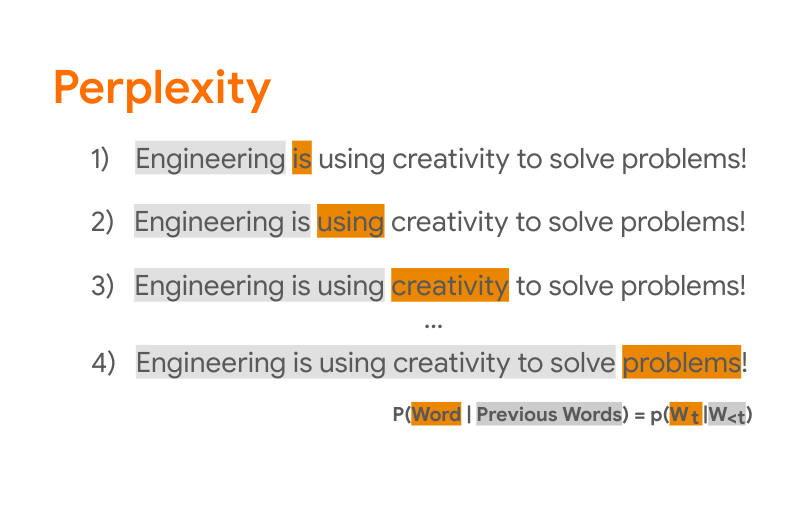

One of the useful metrics for evaluating a Large Language Model is **Perplexity**. Perplexity is a measure of how well a language model predicts the next token in a sequence. It is calculated by taking the exponentiation of the average negative log-likelihood of the next token. A lower perplexity score indicates that the language model is better at predicting the next token.

This is the *formula* for calculating perplexity.

 $\text{Perplexity} = \exp(-1 * $ Average Negative Log Likelihood $) =
  \exp\left(-\frac{1}{T} \sum_{t=1}^T \log p(w_t | w_{<t})\right)$.


If you would like to explore how perplexity metrics work, you experiment on this[ colab notebook](https://colab.research.google.com/drive/18LKpcCwvQtfo_TbG2iMI3ru2QQ0HcQGp?usp=sharing)! You can experiment with computing perplexity for both base GPT-2 model and converted TFLite model. In this colab notebook, we calculate perplexity using [Keras_nlp's perplexity](https://keras.io/api/keras_nlp/metrics/perplexity/).

**Computing Perplexity for Base GPT-2 Model and Finetuned Model**

The code below is the function will be used later in the notebook for computing perplexity for the base GPT-2 model and the finetuned model.

In [ ]:
def calculate_perplexity(gpt2_model, gpt2_tokenizer, sentence) -> int:
  """Calculates perplexity of a model given a sentence.

  Args:
    gpt_model: GPT-2 Language Model
    sentence: Sentence that the model's perplexity is calculated upon.

  Returns:
    A perplexity score.
  """
  # gpt2_tokenizer([sentence])[0] produces a tensor containing an array of tokens that form the sentence.
  tokens = gpt2_tokenizer([sentence])[0].numpy()
  # decoded_sentences is an array containing sentences that increase by one token in size.
  # e.g. if tokens for a sentence "I love dogs" are ["I", "love", "dogs"], then decoded_sentences = ["I love", "I love dogs"]
  decoded_sentences = [gpt2_tokenizer.detokenize([tokens[:i]])[0].numpy() for i in range(1, len(tokens))]
  predictions = gpt2_model.predict(decoded_sentences)
  logits = [predictions[i - 1][i] for i in range(1, len(tokens))]
  target = tokens[1:].reshape(len(tokens) - 1, 1)
  perplexity = keras_nlp.metrics.Perplexity(from_logits=True)
  perplexity.update_state(target, logits)
  result = perplexity.result()
  return result.numpy()

def average_perplexity(gpt2_model, gpt2_tokenizer, sentences):
  perplexity_lst = [calculate_perplexity(gpt2_model, gpt2_tokenizer, sent) for sent in sentences]
  return np.mean(perplexity_lst)

**Computing Perplexity for TFLite Models**

Similar to the code above for calculating perplexity for the base model and finetuned GPT-2 model, we also write a function that computes perplexity for TFlite models.

In [ ]:
def calculate_perplexity_tflite(sentence, runner, gpt2_tokenizer, gpt2_preprocessor):
    """Calculates perplexity of a TfLite model given a sentence.

    Args:
      sentence: Sentence that the model's perplexity is calculated upon.
      runner: Object that can be used to run the TensorFlow model's serving_default signature.

    Returns:
      A perplexity score.
    """
    # Tokenize and preprocess the sentence
    tokenized_sentence = gpt2_tokenizer([sentence])[0].numpy()
    ds = tf.data.Dataset.from_tensor_slices([sentence])
    preprocessed_ds = ds.map(gpt2_preprocessor)
    _, token_ids, padding_mask = next(iter(preprocessed_ds))

    # Run the TensorFlow Lite model
    tflite_result = runner(token_ids=tf.expand_dims(token_ids, axis=0), padding_mask=tf.expand_dims(tf.cast(padding_mask, tf.int32), axis=0))
    prediction_key = list(tflite_result.keys())[0]
    tflite_prediction = tflite_result[prediction_key]

    # Extract logits for all tokens
    logits = tflite_prediction[0][1:len(tokenized_sentence)]

    # Target tokens excluding the first token
    target = tokenized_sentence[1:].reshape(len(tokenized_sentence) - 1, 1)

    # Calculate perplexity
    perplexity = keras_nlp.metrics.Perplexity(from_logits=True)
    perplexity.update_state(target, logits)
    result = perplexity.result()

    return result.numpy()

def average_perplexity_tflite(sentences, runner):
    gpt2_tokenizer = keras_nlp.models.GPT2Tokenizer.from_preset("gpt2_base_en")
    gpt2_preprocessor = keras_nlp.models.GPT2CausalLMPreprocessor.from_preset(
        "gpt2_base_en",
        sequence_length=256,
        add_end_token=True,
    )
    perplexity_lst = [calculate_perplexity_tflite(sent, runner, gpt2_tokenizer, gpt2_preprocessor) for sent in sentences]
    return np.mean(perplexity_lst)

# Evaluator Component

Now that we have all the helper functions required for the Evaluator component, we will define a evaluator component. Evaluator component makes inferences with base, fine-tuned, TFlite, and quantized models, calculates perplexity for all models, and also records inference time. Output of the evaluator component contains information useful for assessing each model.

In [ ]:
@tfx.dsl.components.component
def Evaluation(
    examples: tfx.dsl.components.InputArtifact[
        tfx.types.standard_artifacts.Examples
    ],
    trained_model: tfx.dsl.components.InputArtifact[
        tfx.types.standard_artifacts.Model
    ],
    tflite_model: tfx.dsl.components.InputArtifact[TFLite],
    quantized_model: tfx.dsl.components.InputArtifact[TFLite],
    max_length: tfx.dsl.components.Parameter[int],
    evaluation: tfx.dsl.components.OutputArtifact[EvaluationMetric],
) -> None:
  """Makes inferences with base model, finetuned model, TFlite model, and quantized model.

  Args:
    examples: Standard TFX examples artifacts for retreiving test dataset.
    trained_model: Standard TFX trained model artifact finetuned with Multi-News
      dataset.
    tflite_model: Unquantized TFLite model.
    quantized_model: Quantized TFLite model.
    max_length: Length of the text that the model generates given custom input
      statements.
    evaluation: An evaluation artifact that saves predicted outcomes of custom
      inputs in a csv document and inference speed of the model.
  """
  _TEST_SIZE = 10

  path = os.path.join(examples.uri, 'Split-eval')
  test_data = input_fn(path)
  evaluation_inputs = [
      trim_sentence(article, max_words=_INPUT_LENGTH)
      for article in test_data[:_TEST_SIZE]
  ]
  true_test = [
      trim_sentence(article, max_words=max_length)
      for article in test_data[:_TEST_SIZE]
  ]

  # Loading base model, making inference, and calculating perplexity on the base model.
  gpt2_preprocessor = keras_nlp.models.GPT2CausalLMPreprocessor.from_preset(
      'gpt2_base_en',
      sequence_length=256,
      add_end_token=True,
  )
  gpt2_lm = keras_nlp.models.GPT2CausalLM.from_preset(
      'gpt2_base_en', preprocessor=gpt2_preprocessor
  )
  gpt2_tokenizer = keras_nlp.models.GPT2Tokenizer.from_preset('gpt2_base_en')

  base_average_perplexity = average_perplexity(
      gpt2_lm, gpt2_tokenizer, true_test
  )

  start_base_model = time.time()
  base_evaluation = [
      gpt2_lm.generate(input, max_length).numpy().decode('utf-8')
      for input in evaluation_inputs
  ]
  end_base_model = time.time()

  # Loading finetuned model and making inferences with the finetuned model.
  model_weights = os.path.join(
      trained_model.uri, 'Format-Serving', 'model_weights'
  )
  gpt2_lm.load_weights(model_weights)

  trained_model_average_perplexity = average_perplexity(
      gpt2_lm, gpt2_tokenizer, true_test
  )

  start_trained = time.time()
  trained_evaluation = [
      gpt2_lm.generate(input, max_length).numpy().decode('utf-8')
      for input in evaluation_inputs
  ]
  end_trained = time.time()

  from tensorflow.lite.python import interpreter
  # Loading TFLite model and making inference with TFLite model.
  with open(
      os.path.join(tflite_model.uri, 'quantized_gpt2_generate.tflite'), 'rb'
  ) as generate_file:
    tflite_model_generate = generate_file.read()
  with open(
      os.path.join(tflite_model.uri, 'quantized_gpt2_runner.tflite'), 'rb'
  ) as runner_file:
    tflite_model_runner_file = runner_file.read()
  tflite_model_runner = create_runner(tflite_model_runner_file)

  tflite_model_average_perplexity = average_perplexity_tflite(
      true_test, tflite_model_runner
  )

  start_tflite = time.time()
  interp = interpreter.InterpreterWithCustomOps(
      model_content=tflite_model_generate,
      custom_op_registerers=tf_text.tflite_registrar.SELECT_TFTEXT_OPS)
  interp.get_signature_list()

  generator = interp.get_signature_runner('serving_default')
  tflite_evaluation = [
      run_inference(input, generator) for input in evaluation_inputs
  ]
  end_tflite = time.time()

  # Loading quantized model and making inference with Quantized model.
  with open(
      os.path.join(quantized_model.uri, 'quantized_gpt2_generate.tflite'), 'rb'
  ) as generate_file:
    quantized_model_generate = generate_file.read()
  with open(
      os.path.join(quantized_model.uri, 'quantized_gpt2_runner.tflite'), 'rb'
  ) as runner_file:
    quantized_model_runner_file = runner_file.read()
  quantized_model_runner = create_runner(quantized_model_runner_file)

  quantized_model_average_perplexity = average_perplexity_tflite(
      true_test, quantized_model_runner
  )

  start_quantized = time.time()
  interp = interpreter.InterpreterWithCustomOps(
      model_content=quantized_model_generate,
      custom_op_registerers=tf_text.tflite_registrar.SELECT_TFTEXT_OPS)
  interp.get_signature_list()

  generator = interp.get_signature_runner('serving_default')
  quantized_evaluation = [
      run_inference(input, generator)
      for input in evaluation_inputs
  ]
  end_quantized = time.time()

  # Building an inference table.
  inference_data = {
      'input': evaluation_inputs,
      'actual_test_output': true_test,
      'base_model_prediction': base_evaluation,
      'trained_model_prediction': trained_evaluation,
      'tflite_evaluation_prediction': tflite_evaluation,
      'quantized_model_prediction': quantized_evaluation,
  }

  models = [
      'Base Model',
      'Finetuned Model',
      'TFLite Model',
      'Quantized Model',
  ]
  inference_time = [
      (end_base_model - start_base_model),
      (end_trained - start_trained),
      (end_tflite - start_tflite),
      (end_quantized - start_quantized),
  ]
  average_inference_time = [time / _TEST_SIZE for time in inference_time]
  average_perplexity_lst = [
      base_average_perplexity,
      trained_model_average_perplexity,
      tflite_model_average_perplexity,
      quantized_model_average_perplexity,
  ]
  evaluation_data = {
      'Model': models,
      'Average Inference Time': average_inference_time,
      'Average Perplexity': average_perplexity_lst,
  }

  # creating directory in examples artifact to save metric dataframes
  metrics_path = os.path.join(examples.uri, 'metrics')
  if not os.path.exists(metrics_path):
      os.mkdir(metrics_path)

  evaluation_df = pd.DataFrame(evaluation_data).set_index('Model').transpose()
  evaluation_path = os.path.join(metrics_path, 'evaluation_output.csv')
  evaluation_df.to_csv(evaluation_path, index=False)

  inference_df = pd.DataFrame(inference_data)
  inference_path = os.path.join(metrics_path, 'inference_output.csv')
  inference_df.to_csv(inference_path, index=False)
  evaluation.model_evaluation_output_path = inference_path

In [ ]:
evaluation_model = Evaluation(examples = example_gen.outputs['examples'],  trained_model = trainer.outputs['model'], quantized_model = quantized_model.outputs['tflite_model'], tflite_model = tflite_model.outputs['tflite_model'], max_length = 100)

In [ ]:
context.run(evaluation_model, enable_cache = False)

Once our evaluation component execution is completed, we will load the results and display them.

In [ ]:
examples = example_gen.outputs['examples']
evaluation_path = os.path.join(examples.get()[0].uri, 'metrics')
inference_df = pd.read_csv(os.path.join(evaluation_path, 'inference_output.csv' ))
evaluation_df = pd.read_csv(os.path.join(evaluation_path, 'evaluation_output.csv' ))

In [ ]:
from IPython import display
display.display(display.HTML(inference_df.to_html()))
display.display(display.HTML(evaluation_df.to_html()))

# Running the Entire Pipeline

TFX supports multiple orchestrators to run pipelines. In this tutorial we will use LocalDagRunner which is included in the TFX Python package and runs pipelines on local environment. We often call TFX pipelines "DAGs" which stands for directed acyclic graph.

LocalDagRunner provides fast iterations for development and debugging. TFX also supports other orchestrators including Kubeflow Pipelines and Apache Airflow which are suitable for production use cases. See [TFX on Cloud AI Platform Pipelines](https://www.tensorflow.org/tfx/tutorials/tfx/cloud-ai-platform-pipelines) or [TFX Airflow](https://www.tensorflow.org/tfx/tutorials/tfx/airflow_workshop) Tutorial to learn more about other orchestration systems.

Now we create a LocalDagRunner and pass a Pipeline object created from the function we already defined. The pipeline runs directly and you can see logs for the progress of the pipeline including ML model training.

In [ ]:
import urllib.request
import tempfile
import os


PIPELINE_NAME = "tfx-llm-multi-news"
model_fn = "modules.model.run_fn"
_transform_module_file = "modules/_transform_module.py"

# Output directory to store artifacts generated from the pipeline.
PIPELINE_ROOT = os.path.join('pipelines', PIPELINE_NAME)
# Path to a SQLite DB file to use as an MLMD storage.
METADATA_PATH = os.path.join('metadata', PIPELINE_NAME, 'metadata.db')
# Output directory where created models from the pipeline will be exported.
SERVING_MODEL_DIR = os.path.join('serving_model', PIPELINE_NAME)

from absl import logging
logging.set_verbosity(logging.INFO)  # Set default logging level.

**NOTE:** If you would like to create multiple objects from the same component (as in the case of creating tflite_model and quantized_model from Conversion component in this pipeline), you need to specify the object by '.with_id()'. An example of this practice is in the code below.

In [ ]:
def _create_pipeline(
    pipeline_name: str,
    pipeline_root: str,
    model_fn: str,
    serving_model_dir: str,
    metadata_path: str,
) -> tfx.dsl.Pipeline:
  """Creates a Pipeline for Fine-Tuning and Converting an Large Language Model with TFX."""

  example_gen = FileBasedExampleGen(
    input_base='dummy',
    custom_config={'dataset':'multi_news', 'split':'train[:20%]'},
    custom_executor_spec=executor_spec.BeamExecutorSpec(TFDSExecutor))

  statistics_gen = tfx.components.StatisticsGen(
      examples=example_gen.outputs['examples'], exclude_splits=['eval']
  )

  schema_gen = tfx.components.SchemaGen(
      statistics=statistics_gen.outputs['statistics'],
      infer_feature_shape=False,
      exclude_splits=['eval'],
  )

  example_validator = tfx.components.ExampleValidator(
      statistics=statistics_gen.outputs['statistics'],
      schema=schema_gen.outputs['schema'],
      exclude_splits=['eval'],
  )

  preprocessor = tfx.components.Transform(
    examples=example_gen.outputs['examples'],
    schema=schema_gen.outputs['schema'],
    module_file= _transform_module_file,
  )

  trainer = tfx.components.Trainer(
      run_fn=model_fn,
      examples=example_gen.outputs['examples'],
      train_args=tfx.proto.TrainArgs(splits=['train']),
      eval_args=tfx.proto.EvalArgs(splits=['train']),
      schema=schema_gen.outputs['schema'],
  )

  quantized_model = Conversion(
      trained_model=trainer.outputs['model'], is_quantized=True
  ).with_id('quantized model')

  tflite_model = Conversion(
      trained_model=trainer.outputs['model'], is_quantized=False
  ).with_id('tflite model')

  evaluation_model = Evaluation(
      examples=example_gen.outputs['examples'],
      trained_model=trainer.outputs['model'],
      quantized_model=quantized_model.outputs['tflite_model'],
      tflite_model=tflite_model.outputs['tflite_model'],
      max_length=100,
  )

  # Following 9 components will be included in the pipeline.
  components = [
      example_gen,
      statistics_gen,
      schema_gen,
      example_validator,
      preprocessor,
      trainer,
      quantized_model,
      tflite_model,
      evaluation_model,
  ]

  return tfx.dsl.Pipeline(
      pipeline_name=pipeline_name,
      pipeline_root=pipeline_root,
      metadata_connection_config=tfx.orchestration.metadata.sqlite_metadata_connection_config(
          metadata_path
      ),
      components=components,
  )

In [ ]:
tfx.orchestration.LocalDagRunner().run(
    _create_pipeline(
        pipeline_name=PIPELINE_NAME,
        pipeline_root=PIPELINE_ROOT,
        model_fn=model_fn,
        serving_model_dir=SERVING_MODEL_DIR,
        metadata_path=METADATA_PATH,
    )
)

You should see INFO:absl:Component Evaluation is finished." at the end of the logs if the pipeline finished successfully because evaluation component is the last component of the pipeline.